In [1]:
import json
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import cameo
from scipy import stats
from Bio import SeqIO
import numpy as np

In [2]:
genome = SeqIO.read("../Data/Mutation_data/MG1655.gb", "genbank")

In [3]:
%matplotlib inline

In [4]:
with open("../Data/Mutation_data/Mutations_to_gene_names.json") as infile:
    muts_to_genes = json.load(infile)
    
with open("../Data/Mutation_data/Strain_to_genes.json") as infile:
    strains_to_genes = json.load(infile)
    strains_to_genes = {k: v for k, v in strains_to_genes.items() if not k.startswith("12PD")}
    
with open("../Data/Mutation_data/All_strains_to_mutations.json") as infile:
    strains_to_muts = json.load(infile)
    strains_to_muts = {k: v for k, v in strains_to_muts.items() if not k.startswith("12PD")}

metab_dir = "/Users/krisj/Documents/PhD/Projects/ETH/Data/Metabolomics_data/"

fc_df = pd.read_csv(metab_dir + "Fold_changes.tsv", sep="\t", index_col=0)

with open(metab_dir + "all_ion_names.json") as infile:
    ion_names = json.load(infile)
    
with open(metab_dir + "bigg_model_ion_names.json") as infile:
    model_ion_names = json.load(infile)

muts_to_strains = {}
for s, muts in strains_to_muts.items():
    for mut in muts:
        muts_to_strains.setdefault(mut, []).append(s)

In [5]:
comp_name_order = [
    "1,2-propanediol", "2,3-butanediol", "HMDA", "putrescine", "glutarate",
    "adipate", "hexanoate", "octanoate", "coumarate", "isobutyrate", "butanol", "NaCl"
]

comp_order = ["12PD", "23BD", "HMDA", "PUTR", "GLUT", "ADIP", "HEXA", "OCTA", "COUM", "IBUA", "BUT"]

growth_df = pd.read_csv("../Data/Growth_data/Cross_tolerance/Cleaned_growth_rates.tsv", sep="\t")
long_growth_df = growth_df.copy()
growth_df = growth_df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "rel_growth_rate")[comp_name_order]
raw_growth_df = long_growth_df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "growth_rate")


m9_growth = pd.read_csv("../Data/Growth_data/M9/M9_normalised_growth.csv")
m9_growth = m9_growth[m9_growth["growth_rate"] != 0].groupby("strain").mean()

growth_df["M9"] = m9_growth["rel_growth_rate"]

In [6]:
model = cameo.load_model("iJO1366")

In [7]:
def tol_metric(row):
        
    if pd.isnull(row["coumarate"]):
        coum = row[comp_name_order].mean()
    else:
        coum = row["coumarate"]
        
    if pd.isnull(row["isobutyrate"]):
        ibua = row[comp_name_order].mean()
    else:
        ibua = row["isobutyrate"]
    if "butanol" in row:
        if pd.isnull(row["butanol"]):
            but = row[comp_name_order].mean()
        else:
            but = row["butanol"]
    return (
        (
            row[["HMDA", "putrescine"]].mean() + 
            row[["glutarate", "adipate"]].mean() + 
            row[["hexanoate", "octanoate"]].mean()
        )
        + ibua + row["2,3-butanediol"] + coum + but
    )

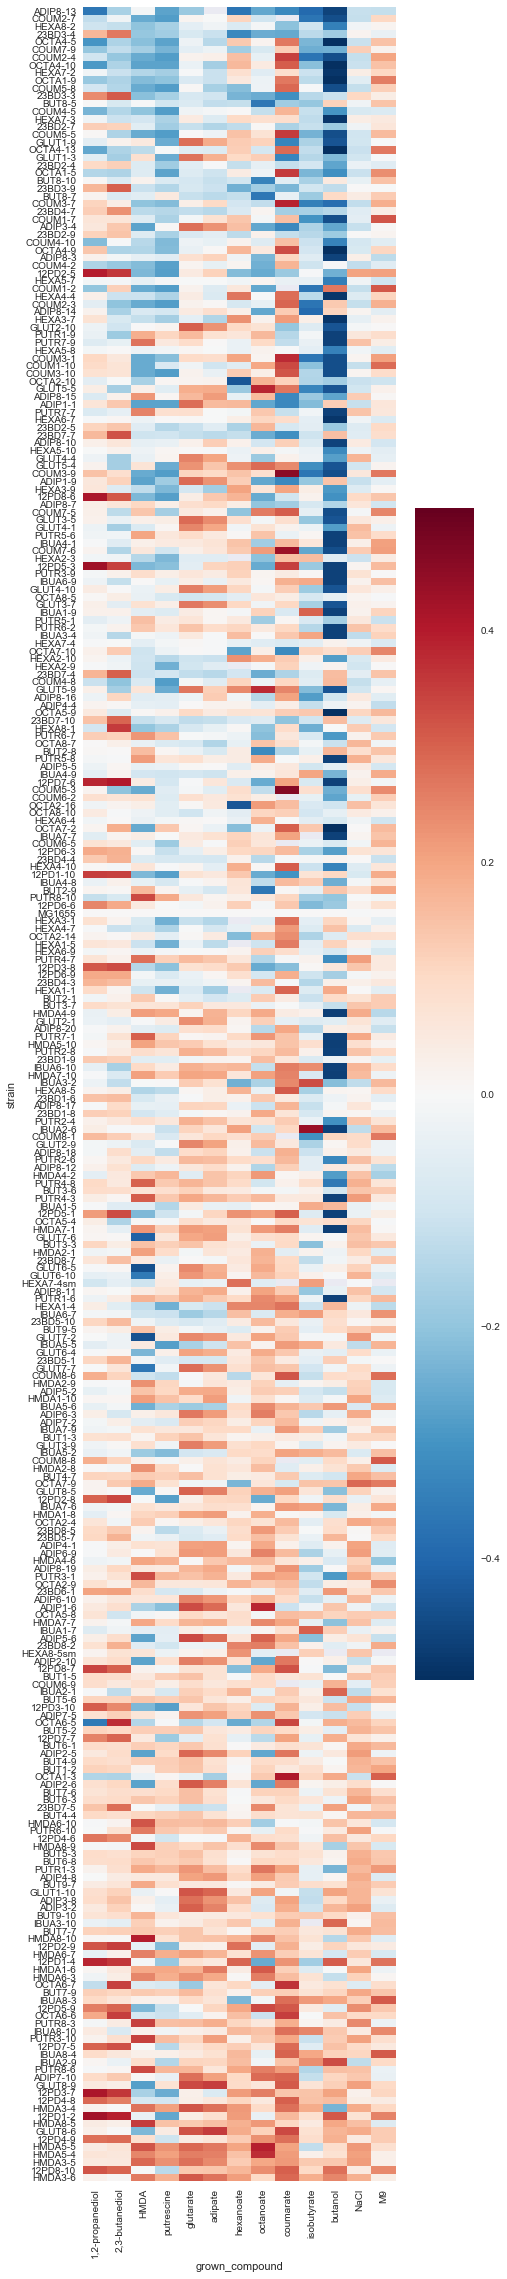

In [8]:
plot_df = growth_df.copy()

plot_df = plot_df.reindex(plot_df.apply(tol_metric, axis=1).sort_values().index)

plt.figure(figsize=[7, 40])
sbn.heatmap(plot_df)

In [9]:
strains_to_genes["HMDA3-6"]

['gatY', 'rpoC', 'nagA', 'pyrE', 'kup']

/Users/krisj/anaconda/envs/cfb_old/lib/python3.4/site-packages/scipy/stats/stats.py:1713 FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


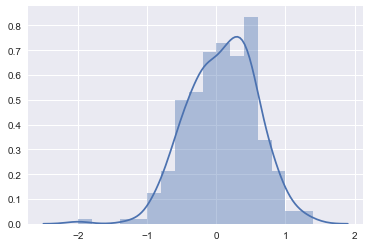

In [10]:
sbn.distplot(growth_df.apply(tol_metric, axis=1))

In [11]:
plot_df[plot_df.index.isin(strains_to_genes)].apply(tol_metric, axis=1)

strain
COUM2-7    -1.239220
HEXA8-2    -1.036932
COUM2-4    -0.855616
OCTA4-10   -0.837647
HEXA7-2    -0.829225
OCTA1-9    -0.820653
COUM5-8    -0.781187
COUM4-5    -0.708120
23BD2-7    -0.657719
COUM5-5    -0.654709
GLUT1-9    -0.647743
OCTA4-13   -0.615861
GLUT1-3    -0.615403
23BD2-4    -0.606817
OCTA1-5    -0.598132
23BD4-7    -0.552999
ADIP3-4    -0.544156
23BD2-9    -0.535959
COUM4-10   -0.534626
OCTA4-9    -0.518757
ADIP8-3    -0.514830
COUM4-2    -0.504672
COUM1-2    -0.472900
HEXA4-4    -0.470523
COUM2-3    -0.462207
HEXA3-7    -0.440781
GLUT2-10   -0.438618
PUTR7-9    -0.427208
COUM3-1    -0.416570
COUM3-10   -0.403412
              ...   
BUT4-4      0.512717
PUTR6-10    0.521015
HMDA8-9     0.540589
BUT5-3      0.542795
BUT6-8      0.548126
ADIP4-8     0.554754
BUT9-7      0.570705
GLUT1-10    0.598067
ADIP3-8     0.607928
ADIP3-2     0.626797
BUT9-10     0.662484
IBUA3-10    0.670181
BUT7-7      0.670252
HMDA8-10    0.671408
BUT7-9      0.730511
IBUA8-3     0.746281
PUTR8-

In [12]:
def pop_genes(pop):
    pop_strains = [s for s in strains_to_genes if s.startswith(pop)]
    for s in pop_strains:
        print(strains_to_genes[s])
    return set.intersection(*[set(strains_to_genes[s]) for s in pop_strains])

In [13]:
pop_genes("HMDA8")

['mdtK', 'nagC', 'proV', 'pyrE', 'lhr', 'rnt']
['mpl', 'mdtK', 'nagC', 'proV', 'pyrE', 'lhr', 'rnt']
['mdtK', 'xapR', 'nagC', 'proV', 'cynR', 'pyrE', 'lhr', 'rnt']


{'lhr', 'mdtK', 'nagC', 'proV', 'pyrE', 'rnt'}

In [14]:
[s for s, gs in strains_to_genes.items() if "ptsP" in gs]

['HMDA5-5', 'HMDA5-4', 'IBUA1-7', 'HMDA5-10', 'HMDA2-8', 'HMDA2-1']

In [15]:
plot_df = growth_df.copy()
plot_df["global"] = plot_df.apply(tol_metric, axis=1)
plot_df["comp"] = plot_df.index.map(lambda x: x.split("-")[0][:-1])
plot_df.to_csv("../../Data/Global_tolerance_dataframe.csv")

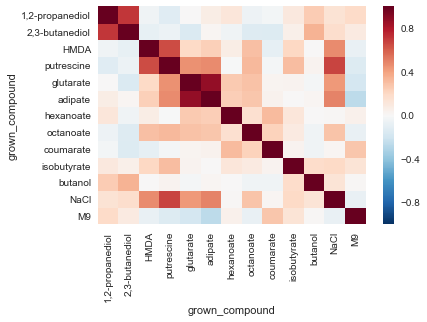

In [16]:
sbn.heatmap(growth_df.corr())

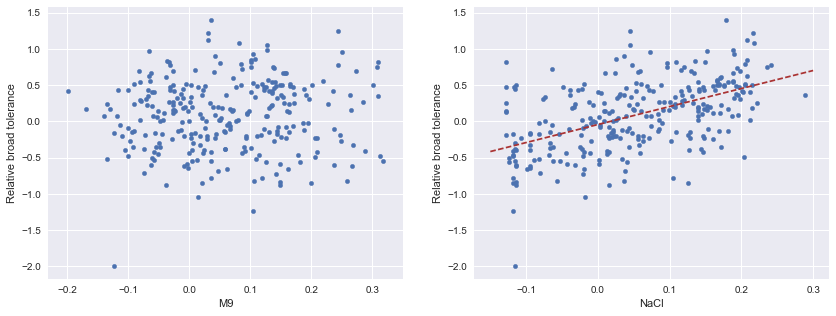

In [17]:
fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(1, 2, 1)
plot_df.plot(kind="scatter", x="M9", y="global", ax=ax)
plt.ylabel("Relative broad tolerance")
ax = fig.add_subplot(1, 2, 2)
plot_df.plot(kind="scatter", x="NaCl", y="global", ax=ax)
plt.ylabel("Relative broad tolerance")
regress = stats.linregress(plot_df["NaCl"], plot_df["global"])
X = np.array([-0.15, 0.3])
plt.plot(X, regress.slope * X + regress.intercept, "--", color="#aa3333")
#plt.ylim([-1.4, 1.5])

/Users/krisj/anaconda/envs/cfb_old/lib/python3.4/site-packages/seaborn/categorical.py:584 FutureWarning: remove_na is deprecated and is a private function. Do not use.
/Users/krisj/anaconda/envs/cfb_old/lib/python3.4/site-packages/scipy/stats/stats.py:1713 FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(0.06097564624928875, 0.310169640208795)
(0.5216830967866359, 5.150795277338567e-21)


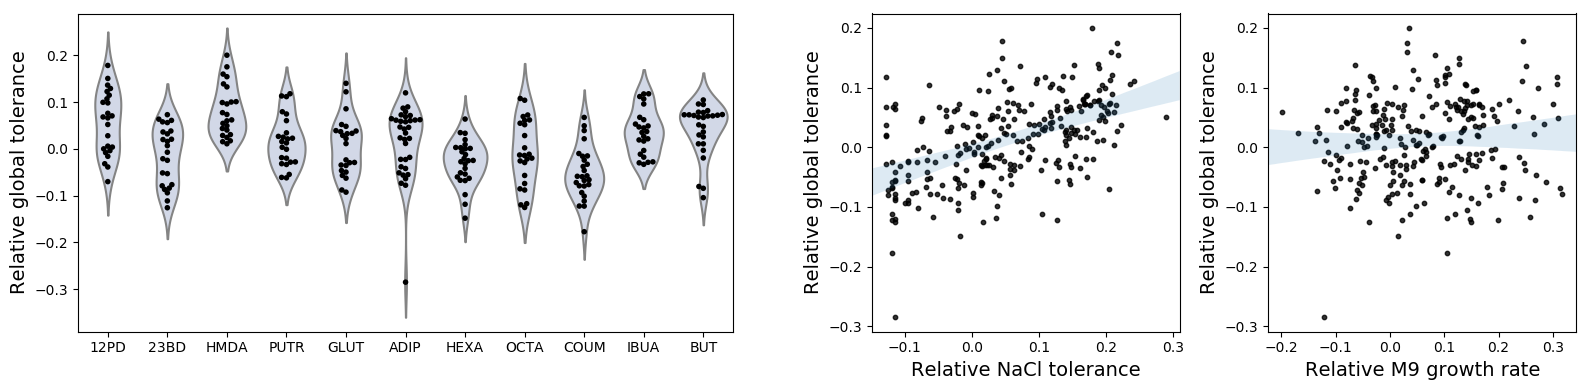

In [82]:
plt.style.use("default")
plt.figure(figsize=[16, 4])

fs = 14

plot_df = growth_df.copy()
plot_df["global"] = plot_df.apply(tol_metric, axis=1) / 7
plot_df["comp"] = plot_df.index.map(lambda x: x.split("-")[0][:-1])
plot_df = plot_df[plot_df["comp"] != "MG165"]
plot_df = plot_df.reindex(sorted(plot_df.index, key=lambda x: comp_order.index(plot_df["comp"][x])))

plt.subplot(1, 2, 1)
#plt.grid(axis="y", zorder=1)
sbn.violinplot(x="comp", y="global", data=plot_df, inner=None, color="#d2d8e7", zorder=10, saturation=1)
sbn.swarmplot(
    x="comp", y="global", data=plot_df,
    color="black",
    size=4, zorder=15
)
plt.xlabel("")
plt.ylabel("Relative global tolerance", fontsize=fs)


plt.subplot(1, 4, 4)
sbn.regplot(x="M9", y="global", data=plot_df, ci=99, n_boot=10000, line_kws={"alpha": 0, "color": None}, scatter_kws={"s": 10, "color": "black"})
plt.xlabel("Relative M9 growth rate", fontsize=fs)
plt.ylabel("Relative global tolerance", fontsize=fs)

pearson_df = plot_df[["M9", "global"]].dropna()
print(stats.pearsonr(pearson_df["M9"], pearson_df["global"]))

plt.subplot(1, 4, 3)
sbn.regplot(x="NaCl", y="global", data=plot_df, ci=99, n_boot=10000, line_kws={"alpha": 0.0, "color": None}, scatter_kws={"s": 10, "color": "black"})
plt.xlabel("Relative NaCl tolerance", fontsize=fs)
plt.ylabel("Relative global tolerance", fontsize=fs)

pearson_df = plot_df[["NaCl", "global"]].dropna()
print(stats.pearsonr(pearson_df["NaCl"], pearson_df["global"]))

plt.tight_layout()

plt.savefig("../Plots/Figure 3d - Global tolerance correlations.pdf", transparent=True)

In [412]:
[m for m, gs in muts_to_genes.items() if "pyrE" in gs and not m.startswith("DUP") and m in muts_to_strains]

['DEL-3815808-1', 'DEL-3815810-1', 'SNP-3815823-A']

In [413]:
cds_list = [f for f in genome.features if f.type == "CDS"]
feat_pyrE = [f for f in cds_list if f.qualifiers["gene"][0] == "pyrE"]
assert(len(feat_pyrE) == 1)
feat_pyrE = feat_pyrE[0]

In [414]:
feat_pyrE.qualifiers

{'EC_number': ['2.4.2.10'],
 'GO_component': ['GO:0005737 - cytoplasm'],
 'GO_process': ['GO:0006221 - pyrimidine nucleotide biosynthetic process'],
 'codon_start': ['1'],
 'db_xref': ['GI:16131513',
  'ASAP:ABE-0011904',
  'UniProtKB/Swiss-Prot:P0A7E3',
  'EcoGene:EG10808',
  'GeneID:948157'],
 'experiment': ['N-terminus verified by Edman degradation: PMID 6349999'],
 'function': ['enzyme; Pyrimidine ribonucleotide biosynthesis'],
 'gene': ['pyrE'],
 'gene_synonym': ['ECK3632; JW3617'],
 'locus_tag': ['b3642'],
 'product': ['orotate phosphoribosyltransferase'],
 'protein_id': ['NP_418099.1'],
 'transl_table': ['11'],
 'translation': ['MKPYQRQFIEFALSKQVLKFGEFTLKSGRKSPYFFNAGLFNTGRDLALLGRFYAEALVDSGIEFDLLFGPAYKGIPIATTTAVALAEHHDLDLPYCFNRKEAKDHGEGGNLVGSALQGRVMLVDDVITAGTAIRESMEIIQANGATLAGVLISLDRQERGRGEISAIQEVERDYNCKVISIITLKDLIAYLEEKPEMAEHLAAVKAYREEFGV']}

In [415]:
int(feat_pyrE.location.start)

3815126

3815808
3815810
3815823


(3815116, 3815868)

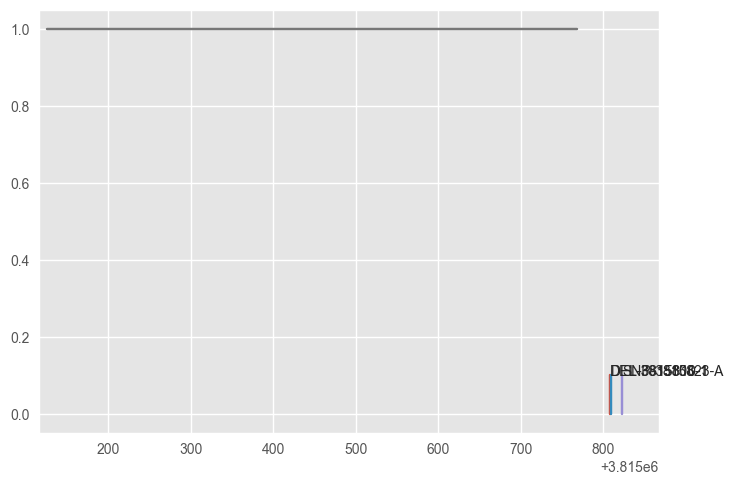

In [416]:
start = int(feat_pyrE.location.start)
stop = start + len(feat_pyrE)

for m in [m for m, gs in muts_to_genes.items() if "pyrE" in gs and not m.startswith("DUP") and m in muts_to_strains]:
    pos = int(m.split("-")[1])
    plt.plot([pos, pos], [0, 0.1],)
    plt.text(pos, 0.1, m)
    print(pos)
plt.plot([start, stop], [1, 1])
plt.plot(0, 0)
plt.xlim([start-10, stop+100])

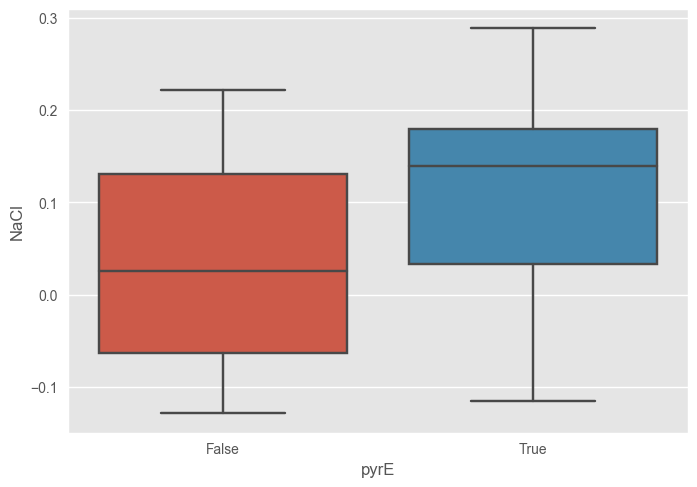

In [417]:
plot_df = pd.DataFrame({
    "global": growth_df.apply(tol_metric, axis=1),
    "M9": growth_df["M9"],
    "NaCl": growth_df["NaCl"],
    "pyrE": growth_df.index.map(lambda x: "pyrE" in strains_to_genes.get(x, [])),
    "nag": growth_df.index.map(lambda x: "nagA" in strains_to_genes.get(x, []) or "nagC" in strains_to_genes.get(x, []))
})
plot_df = plot_df[plot_df.index.isin(strains_to_genes)]
sbn.boxplot(x="pyrE", y="NaCl", data=plot_df)

KeyError: 'nagC'

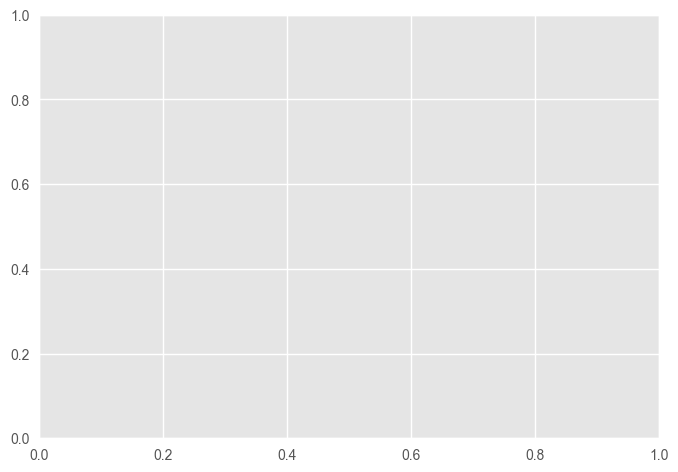

In [418]:
test_df[test_df.index.str.startswith("ADIP")].plot(kind="scatter", x="nagC", y="global")

In [ ]:
test_df[(test_df.index.str.startswith("ADIP")) & (test_df["global"] > 0)].corr()["nagC"].sort_values()

In [421]:

mut_df = pd.DataFrame({s: {g: 1 for g in gs} for s, gs in strains_to_genes.items()}).fillna(0).transpose()
test_df = mut_df.copy()
test_df["global"] = growth_df.apply(tol_metric, axis=1)
test_df[test_df.index.str.startswith("ADIP")].corr("pearson")["global"].sort_values(ascending=False)

global    1.000000
nagC      0.465313
lacY      0.287193
rph       0.287193
yfgO      0.269175
proQ      0.238253
spoT      0.238253
srmB      0.226957
malQ      0.226957
metL      0.226957
nagA      0.226957
pdxJ      0.226957
purL      0.226957
yphC      0.226957
rnt       0.226957
idnR      0.183639
ydcD      0.165786
ybjL      0.149235
icd       0.143011
ycjG      0.143011
rpoS      0.093040
yagL      0.093040
yneO      0.093040
ubiE      0.090066
proV      0.040159
sspA     -0.148116
pyrE     -0.156906
yicC     -0.250176
ligA     -0.270447
allD     -0.270447
            ...   
yfdC           NaN
yffQ           NaN
yfiN           NaN
yfjL           NaN
yfjW           NaN
ygaC           NaN
ygaH           NaN
ygbT           NaN
ygeG           NaN
ygjP           NaN
yhfA           NaN
yhfX           NaN
yhgE           NaN
yhjA           NaN
yhjK           NaN
yiaT           NaN
yieK           NaN
yihQ           NaN
yijD           NaN
yjcF           NaN
yjhG           NaN
yjiP        

In [422]:
mut_df["pyrE"].sum()

55.0

In [423]:
compound_names = {
    "HMDA": "HMDA", "PUTR": "putrescine", "23BD": "2,3-butanediol", "12PD": "1,2-propanediol",
    "HEXA": "hexanoate", "OCTA": "octanoate", "IBUA": "isobutyrate", "COUM": "coumarate", "BUT": "butanol",
    "GLUT": "glutarate", "ADIP": "adipate"
}

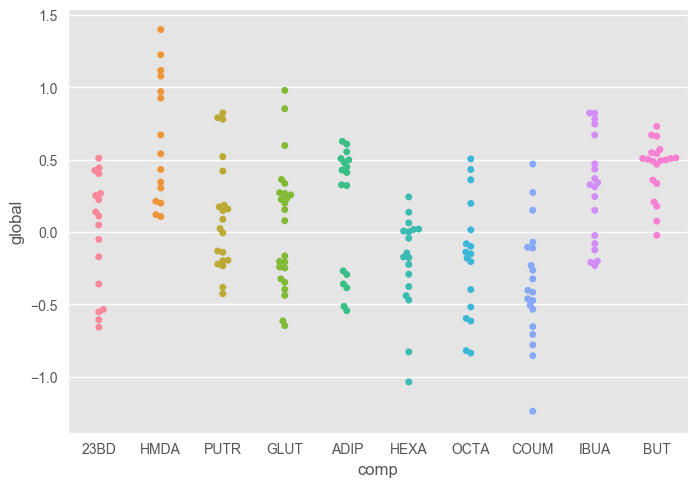

In [424]:
## Boxplot of global tolerance per compound
plt.style.use("ggplot")
plot_df["comp"] = plot_df.index.map(lambda x: x.split("-")[0][:-1])
compounds = list(set(plot_df["comp"]))

palette = sbn.color_palette("deep", 11)

def rgb_to_hex():
    pass


plot_df["evolved_growth"] = plot_df.index.map(lambda x: growth_df.loc[x, compound_names[x.split("-")[0][:-1]]])
plot_df["color"] = plot_df["comp"].map(lambda x: palette[compounds.index(x)])
plot_df = plot_df.reindex(sorted(plot_df.index, key=lambda x: comp_order.index(x.split("-")[0][:-1])))
sbn.swarmplot(x="comp", y="global", data=plot_df)

In [435]:
strains_to_genes["HMDA5-3"]

KeyError: 'HMDA5-3'

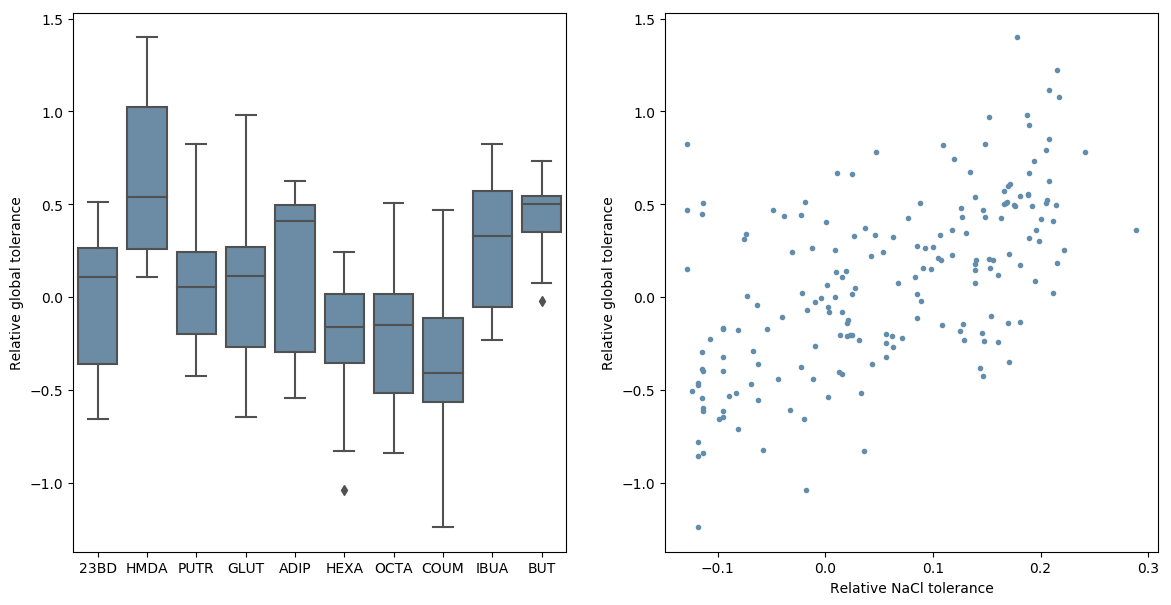

In [431]:
plt.style.use("default")
plt.figure(figsize=[14, 7])
plt.subplot(1, 2, 1)
sbn.boxplot(x="comp", y="global", data=plot_df, color="#628DAD")
plt.ylabel("Relative global tolerance")
plt.xlabel("")

plt.subplot(1, 2, 2)
plt.plot(plot_df["NaCl"], plot_df["global"], ".", color="#628DAD")
plt.xlabel("Relative NaCl tolerance")
plt.ylabel("Relative global tolerance")

In [378]:
test_df = fc_df.copy()
#test_df = test_df[test_df.index.str.startswith("ADIP")]
test_df["global"] = test_df.index.map(plot_df["global"].get)

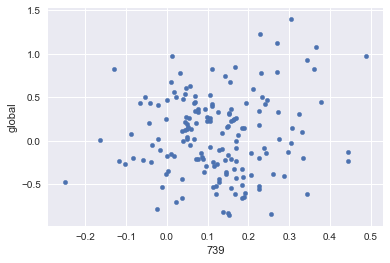

In [379]:
test_df.plot(kind="scatter", x="739", y="global")

In [381]:
test_df.corr()["global"].sort_values()

311      -0.403671
445      -0.370534
859      -0.363636
613      -0.347005
273      -0.339096
885      -0.334486
78       -0.332184
694      -0.328460
119      -0.322360
888      -0.318067
878      -0.314907
270      -0.313275
118      -0.313087
76       -0.309099
612      -0.303231
327      -0.302977
131      -0.300751
227      -0.300310
499      -0.297627
189      -0.293040
661      -0.291668
755      -0.290970
431      -0.289458
910      -0.287238
71       -0.285393
395      -0.281421
297      -0.277449
357      -0.276856
100      -0.275549
77       -0.275387
            ...   
521       0.225139
142       0.231344
537       0.232030
702       0.237679
149       0.239297
941       0.255898
405       0.256028
957       0.257900
891       0.259517
869       0.265606
1006      0.267671
202       0.270908
203       0.270908
253       0.273597
64        0.273835
458       0.278255
364       0.282719
434       0.283486
635       0.291594
435       0.293089
1043      0.295114
484       0.

In [382]:
ion_names[898]

'Menaquinone'

In [350]:
test_df.corr()["global"].sort_values()

739      -0.736542
902      -0.697492
882      -0.646826
904      -0.607688
1037     -0.579215
634      -0.549737
965      -0.542676
1047     -0.540170
926      -0.539407
858      -0.533162
696      -0.532216
841      -0.529769
661      -0.529012
1021     -0.510478
46       -0.508270
448      -0.507208
1000     -0.505154
989      -0.494108
840      -0.493769
209      -0.493121
446      -0.482754
347      -0.482125
885      -0.476389
1048     -0.464644
789      -0.463253
727      -0.454397
310      -0.448623
496      -0.439458
917      -0.437237
979      -0.428702
            ...   
622       0.398354
52        0.406500
432       0.407465
651       0.416436
170       0.419995
624       0.420935
750       0.421644
774       0.421865
374       0.438333
375       0.438333
227       0.441020
340       0.457717
784       0.460639
935       0.466726
298       0.467758
519       0.468352
822       0.478176
895       0.480470
339       0.488306
179       0.513204
825       0.517333
497       0.

In [309]:
(long_growth_df.groupby(
    ["strain", "grown_compound"]
).mean().reset_index().pivot("strain", "grown_compound", "growth_rate")[comp_name_order].loc[
    plot_df[plot_df["comp"] == "ADIP"].sort_values("global").index
])

grown_compound,"1,2-propanediol","2,3-butanediol",HMDA,putrescine,glutarate,adipate,hexanoate,octanoate,coumarate,isobutyrate,butanol,NaCl
strain,,,,,,,,,,,,
ADIP3-4,0.424632,0.298902,0.000000,0.274659,0.466831,0.385373,0.518224,0.000000,0.000000,0.238627,0.205280,0.000000
ADIP8-3,0.393127,0.150507,0.223699,0.207194,0.271329,0.275130,0.346361,0.029815,0.434792,0.332617,0.000000,0.148343
ADIP1-1,0.432151,0.298169,0.000000,0.000000,0.469557,0.317696,0.532135,0.000000,0.000000,0.175710,0.590017,0.000000
ADIP8-10,0.394342,0.224011,0.222876,0.230407,0.214556,0.283870,0.391977,0.167515,0.448053,0.322547,0.000000,0.158856
ADIP1-9,0.421435,0.281213,0.000000,0.087834,0.475729,0.386667,0.494012,0.000000,0.000000,0.199390,0.612746,0.000000
ADIP8-7,0.391903,0.220395,0.320526,0.299843,0.270943,0.264670,0.407807,0.060860,0.201630,0.278538,0.245225,0.186733
ADIP6-3,0.393004,0.076248,0.257852,0.322438,0.451534,0.379588,0.454984,0.518103,0.440455,0.230086,0.423768,0.311121
ADIP7-2,0.351418,0.196795,0.215227,0.191181,0.313713,0.268136,0.404109,0.373990,0.488111,0.372869,0.494787,0.178079
ADIP6-9,0.361337,0.207536,0.272575,0.347919,0.406878,0.369942,0.427153,0.510743,0.489010,0.232287,0.424575,0.326975


In [300]:
growth_df.loc[["ADIP3-2", "ADIP3-4"]]

grown_compound,"1,2-propanediol","2,3-butanediol",HMDA,putrescine,glutarate,adipate,hexanoate,octanoate,coumarate,isobutyrate,butanol,NaCl,M9
strain,,,,,,,,,,,,,
ADIP3-2,0.048741,0.115084,0.004248,-0.036672,0.300272,0.252486,0.091954,-0.075106,0.182612,-0.105283,0.165792,0.208122,-0.065350
ADIP3-4,0.058500,0.135758,-0.269300,0.005404,0.278296,0.226210,0.150226,-0.260741,-0.327355,-0.155360,-0.262246,-0.115185,0.004368


In [342]:
print(sorted(strains_to_genes["ADIP3-2"]))
print(sorted(strains_to_genes["ADIP3-4"]))

['kgtP', 'proV', 'pyrE', 'sspA', 'ybjL', 'yfgO', 'yicC']
['kgtP', 'mltD', 'proV', 'pyrE', 'sspA', 'ybjL', 'yeaR', 'yhiL', 'yicC']


In [344]:
test_df[test_df["sspA"] == 1]

,aceK,acrB,adeP,allD,ampC,argG,arpA,atpI,barA,bglF,...,yliE,yneO,yobF,yphC,yphF,ypjA,ypjC,ytfR,zntR,global
ADIP1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.385919
ADIP1-9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.294039
ADIP3-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.626797
ADIP3-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.544156
ADIP3-8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.607928
ADIP7-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.480834
GLUT1-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.598067
GLUT5-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.324762
GLUT5-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.397611
GLUT5-9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.165630


In [296]:
plot_df[plot_df["comp"] == "ADIP"].sort_values("global").index

,M9,NaCl,global,nag,pyrE,comp,evolved_growth,color,pyrE_mut
strain,,,,,,,,,
ADIP3-4,0.004368,-0.115185,-0.544156,False,True,ADIP,0.226210,"(0.2980392156862745, 0.4470588235294118, 0.690...",False
ADIP8-3,-0.133918,0.033159,-0.514830,False,False,ADIP,0.115967,"(0.2980392156862745, 0.4470588235294118, 0.690...",False
ADIP1-1,0.059234,-0.115185,-0.385919,False,True,ADIP,0.158533,"(0.2980392156862745, 0.4470588235294118, 0.690...",False
ADIP8-10,-0.091319,0.043671,-0.359298,False,False,ADIP,0.124707,"(0.2980392156862745, 0.4470588235294118, 0.690...",False
ADIP1-9,-0.049963,-0.115185,-0.294039,False,True,ADIP,0.227504,"(0.2980392156862745, 0.4470588235294118, 0.690...",False
ADIP8-7,-0.097233,0.062822,-0.268883,False,False,ADIP,0.098935,"(0.2980392156862745, 0.4470588235294118, 0.690...",False
ADIP6-3,-0.019758,0.189392,0.321157,True,False,ADIP,0.215497,"(0.2980392156862745, 0.4470588235294118, 0.690...",False
ADIP7-2,-0.009393,0.062894,0.326232,False,False,ADIP,0.108973,"(0.2980392156862745, 0.4470588235294118, 0.690...",False
ADIP6-9,-0.057039,0.211790,0.411504,True,False,ADIP,0.210778,"(0.2980392156862745, 0.4470588235294118, 0.690...",False


In [272]:
evolution_concentrations = {
    "12PD": 1.1, "23BD": 0.85, "HMDA": 0.33, "PUTR": 0.41, "OCTA": 0.08,
    "HEXA": 0.07, "IBUA": 0.15, "ADIP": 0.35, "GLUT": 0.38, "BUT": 0.22, "COUM": 0.12
}

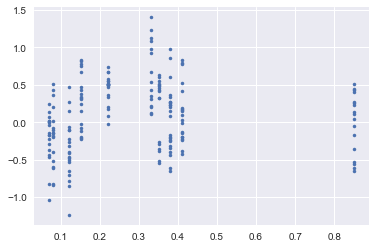

In [273]:
plt.plot(plot_df["comp"].map(evolution_concentrations.get), plot_df["global"], ".")

In [274]:
test_df = plot_df.copy() #[plot_df["comp"] != "23BD"]
stats.spearmanr(test_df["comp"].map(evolution_concentrations.get), test_df["global"])

SpearmanrResult(correlation=0.18627040014517918, pvalue=0.01069500647215222)

In [275]:
sbn.color_palette("deep", 10)

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745)]

In [276]:
sbn.colorsys.rgb_to_hls(*_[0])

(0.6033333333333334, 0.49411764705882355, 0.3968253968253968)

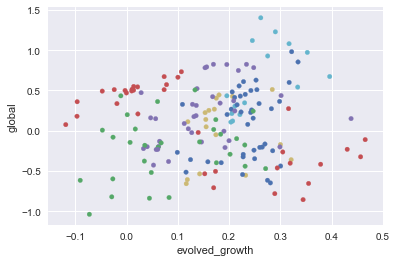

In [277]:
plot_df.plot.scatter(x="evolved_growth", y="global", c=plot_df["color"])
#for comp, col in zip()
#plt.legend()

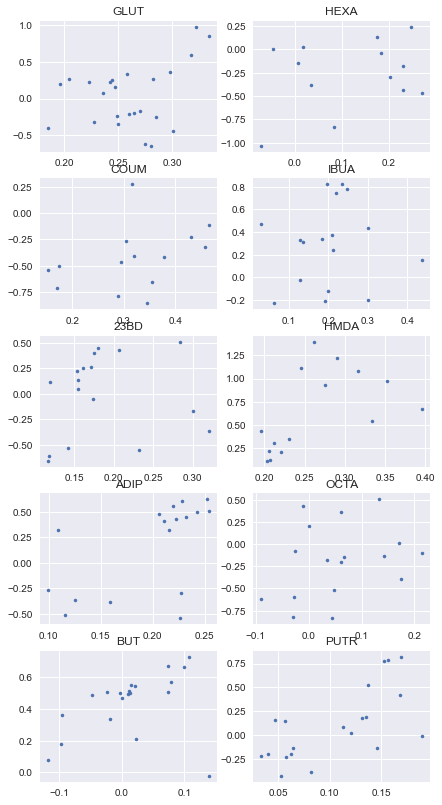

In [278]:
plt.figure(figsize=[7, 14])
for i, comp in enumerate(compounds):
    plt.subplot(5, 2, i+1)
    comp_df = plot_df[plot_df["comp"] == comp]
    # print(comp, comp_df["global"].min())
    plt.plot(comp_df["evolved_growth"], comp_df["global"], ".", label=comp)
    plt.title(comp)

In [279]:
pyrE_mutations = [m for m, gs in muts_to_genes.items() if "pyrE" in gs]

In [280]:
for m in pyrE_mutations:
    if m.startswith("DUP"):
        continue
    if muts_to_strains.get(m):
        print(m, set(muts_to_strains[m]).intersection(set(strains_to_genes)))
        print()

DEL-3815808-1 {'HMDA2-1', 'PUTR8-6', 'OCTA7-2', 'OCTA7-10', 'IBUA6-7', 'PUTR8-3', 'HMDA2-8', 'PUTR8-10', 'HMDA8-10', 'HMDA8-9', 'OCTA7-9', 'HMDA8-5'}

DEL-3815810-1 {'COUM6-2', 'BUT4-4', 'COUM3-10', 'BUT1-3', 'HMDA3-6', 'BUT7-6', 'BUT3-7', 'COUM6-9', 'COUM3-9', 'BUT7-9', 'BUT9-10', 'BUT5-2', 'BUT4-7', 'HMDA5-5', 'ADIP2-10', 'COUM8-1', 'BUT4-9', 'BUT3-6', 'BUT6-3', 'BUT6-1', 'HMDA5-10', 'BUT9-7', 'BUT3-3', 'COUM8-6', 'COUM7-6', 'COUM7-5', '23BD8-2', 'BUT5-3', 'COUM3-1', 'HMDA3-5', 'BUT7-7', 'BUT1-2', '23BD8-7', 'BUT1-5', 'HMDA5-4', 'BUT6-8', 'COUM6-5', 'HMDA3-4'}

SNP-3815823-A {'ADIP1-9', 'ADIP1-1', 'ADIP3-4', 'ADIP3-2', 'ADIP3-8'}



RNA_seq data: PUTR8-10
Proteomics data: OCTA7-10, PUTR8-10, COUM3-9, 

In [ ]:
fpkm

In [281]:
pyrE_strains = []
for m in ["DEL-3815808-1", "DEL-3815810-1"]:
    pyrE_strains.extend(set(muts_to_strains[m]).intersection(set(strains_to_genes)))

In [282]:
strains_to_genes["COUM2-3"]

['rho', 'atpI', 'murC', 'sapF', 'rpoC', 'nadR']

GLUT
HMDA
ADIP
PUTR


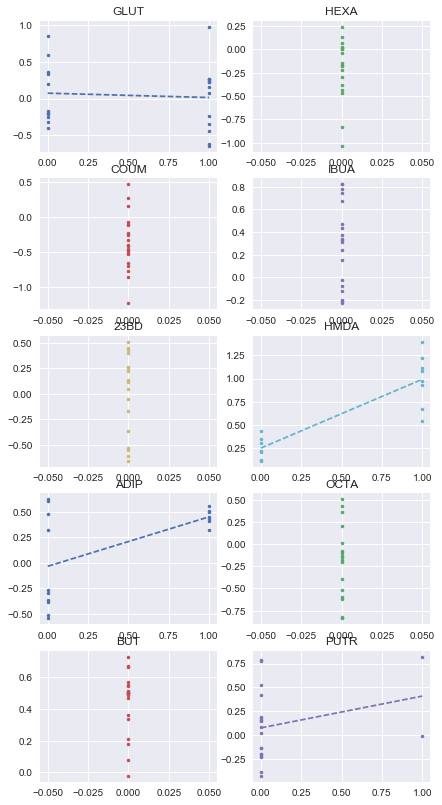

In [293]:
plt.figure(figsize=[7, 14])
plot_df["pyrE_mut"] = plot_df.index.map(pyrE_strains.__contains__)

indep_var = "nag"
dep_var = "global"

for i, comp in enumerate(compounds):
    plt.subplot(5, 2, i+1)
    comp_df = plot_df[plot_df["comp"] == comp]
    # print(comp, comp_df["global"].min())
    plt.plot(comp_df[indep_var] + 0*i/100, comp_df[dep_var], ".", label=comp, color=palette[i])
    if comp_df[indep_var].any():
        print(comp)
        regress = stats.linregress(comp_df[indep_var], comp_df[dep_var])
        X = np.array([0, 1.])
        plt.plot(X, regress.slope * X + regress.intercept, "--", color=palette[i])
    plt.title(comp)
    
#plt.legend()

In [290]:
plot_df.corr()

,M9,NaCl,global,nag,pyrE,evolved_growth,pyrE_mut
M9,1.000000,-0.066313,0.035224,-0.335597,0.229923,-0.100581,0.286135
NaCl,-0.066313,1.000000,0.600677,0.263488,0.294520,-0.117231,0.331536
global,0.035224,0.600677,1.000000,0.295665,0.372550,0.079132,0.394174
nag,-0.335597,0.263488,0.295665,1.000000,0.069601,0.350406,0.098062
pyrE,0.229923,0.294520,0.372550,0.069601,1.000000,-0.080994,0.935902
evolved_growth,-0.100581,-0.117231,0.079132,0.350406,-0.080994,1.000000,-0.110946
pyrE_mut,0.286135,0.331536,0.394174,0.098062,0.935902,-0.110946,1.000000


In [62]:
strains_to_muts["HMDA8-5"]

['SNP-1728512-C',
 'DEL-3815808-1',
 'SNP-1732811-T',
 'DEL-2804864-13',
 'SNP-2522653-A',
 'SNP-358399-G',
 'SNP-700980-C',
 'SNP-1744313-A']

In [35]:
stats.linregress(plot_df["NaCl"], plot_df["global"])

LinregressResult(slope=2.4848760503698171, intercept=-0.043463631625529714, rvalue=0.52171484070285601, pvalue=4.3585304837438639e-21, stderr=0.24283015358702612)

In [34]:
stats.pearsonr(plot_df["NaCl"], plot_df["global"])

(0.5217148407028559, 4.3585304837438443e-21)

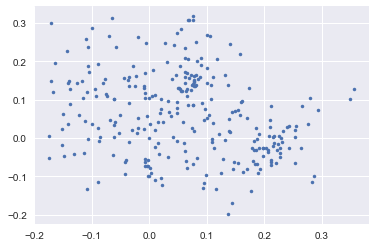

In [33]:
plt.plot(growth_df["adipate"], growth_df["M9"], ".")

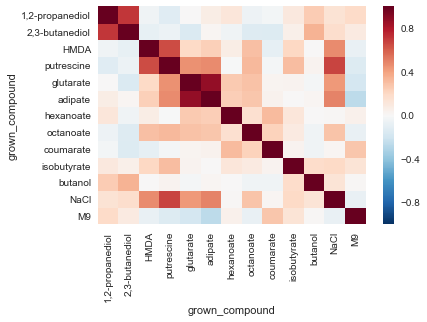

In [146]:
sbn.heatmap(growth_df.corr())

In [87]:
hmda_gene_df = pd.DataFrame(
    {k: {g: 1 for g in v} for k, v in strains_to_genes.items() if k.startswith("HMDA")}
).fillna(0).transpose()
hmda_gene_df["tol"] = hmda_gene_df.index.map(growth_df.apply(tol_metric, axis=1).get)

hmda_gene_df = hmda_gene_df[hmda_gene_df.corr()["tol"].sort_values().index]

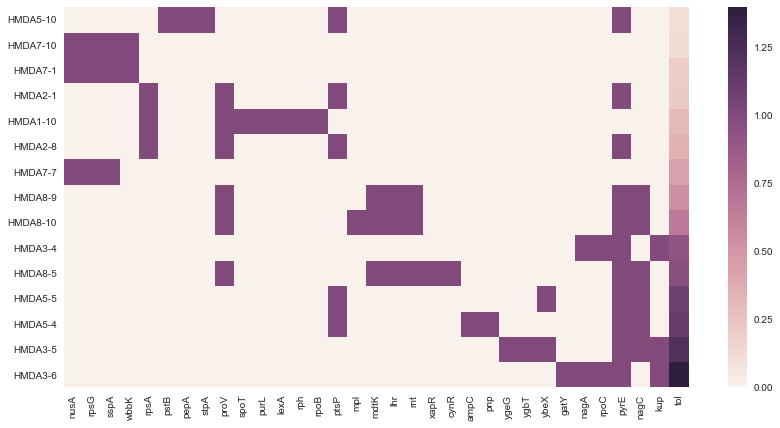

In [149]:
plt.figure(figsize=[14, 7])
sbn.heatmap(hmda_gene_df.sort_values("tol"))

In [158]:
stats.pearsonr(hmda_gene_df["tol"], (hmda_gene_df["nagA"] + hmda_gene_df["nagC"]))

(0.87389733858127527, 2.0612449739399058e-05)

In [86]:
hmda_gene_df.corr()["tol"].sort_values()

nusA   -0.461363
rpsG   -0.461363
sspA   -0.461363
wbbK   -0.445706
rpsA   -0.418316
pstB   -0.337171
pepA   -0.337171
stpA   -0.337171
proV   -0.260796
spoT   -0.212906
purL   -0.212906
lexA   -0.212906
rph    -0.212906
rpoB   -0.212906
ptsP   -0.118650
mpl     0.017629
mdtK    0.098907
lhr     0.098907
rnt     0.098907
xapR    0.205485
cynR    0.205485
ampC    0.297643
pnp     0.297643
ygeG    0.365726
ygbT    0.365726
ybeX    0.468837
gatY    0.474995
nagA    0.478900
rpoC    0.478900
pyrE    0.537414
nagC    0.557630
kup     0.635057
tol     1.000000
Name: tol, dtype: float64

In [74]:
[k + ": " + str(v) for k, v in strains_to_genes.items() if k.startswith("HMDA")]

["HMDA7-10: ['nusA', 'rpsG', 'sspA', 'wbbK']",
 "HMDA1-10: ['purL', 'spoT', 'proV', 'rpoB', 'lexA', 'rpsA', 'rph']",
 "HMDA7-1: ['nusA', 'rpsG', 'sspA', 'wbbK']",
 "HMDA2-1: ['ptsP', 'proV', 'rpsA', 'pyrE']",
 "HMDA5-10: ['ptsP', 'pyrE', 'pstB', 'stpA', 'pepA']",
 "HMDA7-7: ['nusA', 'rpsG', 'sspA']",
 "HMDA3-6: ['pyrE', 'rpoC', 'gatY', 'kup', 'nagA']",
 "HMDA8-9: ['pyrE', 'rnt', 'mdtK', 'proV', 'lhr', 'nagC']",
 "HMDA8-5: ['pyrE', 'cynR', 'rnt', 'mdtK', 'proV', 'lhr', 'nagC', 'xapR']",
 "HMDA2-8: ['pyrE', 'proV', 'ptsP', 'rpsA']",
 "HMDA5-5: ['ptsP', 'nagC', 'ybeX', 'pyrE']",
 "HMDA3-5: ['pyrE', 'ygbT', 'ygeG', 'ybeX', 'kup', 'nagC']",
 "HMDA5-4: ['pnp', 'ampC', 'nagC', 'ptsP', 'pyrE']",
 "HMDA3-4: ['pyrE', 'rpoC', 'kup', 'nagA']",
 "HMDA8-10: ['pyrE', 'rnt', 'mdtK', 'lhr', 'proV', 'mpl', 'nagC']"]

In [62]:
plot_df.corr()["global"].sort_values()

grown_compound
M9                 0.061295
1,2-propanediol    0.335124
hexanoate          0.347299
2,3-butanediol     0.350622
coumarate          0.352243
glutarate          0.379744
HMDA               0.386408
octanoate          0.397410
adipate            0.457195
putrescine         0.505985
isobutyrate        0.513903
NaCl               0.521715
butanol            0.613821
global             1.000000
Name: global, dtype: float64

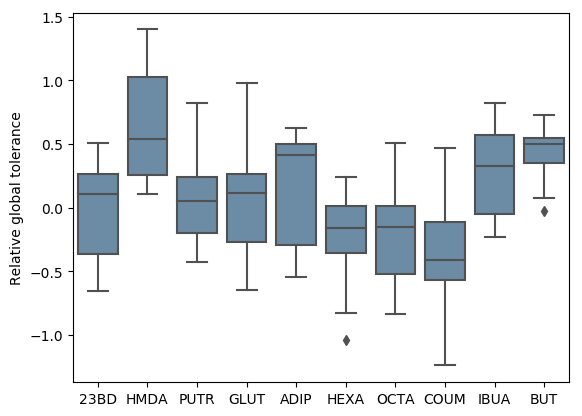

In [403]:
plt.style.use("default")
sbn.boxplot(x="comp", y="global", data=plot_df, color="#628DAD")
plt.ylabel("Relative global tolerance")
plt.xlabel("")

In [43]:
plot_df.corr("pearson")["global"].sort_values()

grown_compound
hexanoate          0.276358
coumarate          0.278378
1,2-propanediol    0.284573
2,3-butanediol     0.366754
glutarate          0.377044
octanoate          0.378003
HMDA               0.397500
adipate            0.435032
putrescine         0.487021
isobutyrate        0.514789
NaCl               0.523678
butanol            0.607229
global             1.000000
Name: global, dtype: float64

In [100]:
fc_df

,strain,36,38,43,44,45,46,50,52,56,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,growth
0,23BD1-6,0.035027,0.083617,0.052528,0.085036,0.140603,0.140844,0.051536,0.120572,0.052707,...,-0.143985,-0.011729,-0.056894,-0.016653,0.091410,-0.012765,-0.024992,0.051019,-0.001874,-0.050983
1,23BD1-9,-0.027824,0.017906,0.040606,0.030120,0.069103,0.007252,-0.016203,0.054919,-0.151079,...,-0.124101,-0.108166,0.011310,0.033274,-0.011844,0.010544,-0.061867,-0.043444,-0.056901,-0.040857
2,23BD2-4,0.062024,0.028936,0.043314,0.020610,0.061160,0.020096,0.003159,0.075022,-0.025524,...,-0.093402,0.045266,0.037738,-0.097257,0.037499,-0.063371,-0.095204,-0.022951,-0.066606,-0.062622
3,23BD2-7,-0.093948,0.046157,0.027965,0.025289,0.029212,0.057429,0.040164,-0.166786,-0.080821,...,-0.042123,-0.064194,-0.069628,-0.004892,-0.051167,0.006037,-0.087049,-0.046826,-0.050143,0.062594
4,23BD2-9,-0.050732,-0.027925,0.004120,-0.008861,-0.156512,-0.005599,0.012088,-0.186005,-0.138510,...,-0.059274,-0.015030,0.051324,-0.117627,0.033973,-0.010156,0.009987,-0.022684,-0.032266,0.012426
5,23BD4-3,-0.009846,0.033237,0.034614,0.001114,0.157630,-0.018579,0.020194,-0.006387,-0.081590,...,-0.040578,-0.100471,0.000876,0.001547,-0.017804,-0.093113,-0.039082,0.045340,0.027285,0.052541
6,23BD4-4,0.013677,0.037561,0.088153,0.111135,-0.021219,0.191156,0.022503,-0.016686,-0.187019,...,-0.074587,-0.103086,0.071087,0.039257,0.071662,0.033314,-0.062365,-0.021607,0.018813,-0.113939
7,23BD4-7,-0.011577,0.081901,0.051800,0.036319,0.153349,0.140003,0.088238,0.044288,-0.020335,...,0.055419,-0.023818,-0.075063,-0.005615,0.067894,0.055048,-0.024671,0.045497,0.045888,0.035903
8,23BD5-1,0.022354,0.051635,0.039855,0.006870,0.007679,0.126178,-0.014486,-0.062462,-0.066894,...,0.053435,-0.134095,0.028649,-0.044467,-0.071115,0.032648,-0.030659,-0.026755,-0.026751,0.001808
9,23BD5-10,-0.028733,-0.036279,0.036512,-0.002016,0.081674,0.133684,0.006368,-0.069447,0.090229,...,-0.001662,-0.077938,-0.001738,0.029550,-0.007697,0.038745,-0.026247,-0.055326,0.019232,0.033512


In [116]:
test_df = fc_df[fc_df.index.str.startswith("HMDA")].copy()
print(test_df.shape)
test_df = test_df[[c for c in test_df.columns if not c == "growth" and model_ion_names[int(c)]]]
print(test_df.shape)
test_df["tol"] = test_df.index.map(hmda_gene_df["tol"].get)

(15, 811)
(15, 431)


In [117]:
test_df.corr()["tol"].sort_values()

850    -0.817409
298    -0.792215
144    -0.788803
344    -0.764756
667    -0.745388
698    -0.734588
481    -0.732782
656    -0.723883
141    -0.707000
118    -0.698757
139    -0.695593
120    -0.693586
287    -0.686218
286    -0.682717
838    -0.682507
116    -0.680042
345    -0.660633
198    -0.658013
279    -0.654993
115    -0.654649
280    -0.648616
132    -0.640921
581    -0.640546
360    -0.639329
247    -0.637320
451    -0.635117
650    -0.634710
215    -0.633764
935    -0.622151
237    -0.608377
          ...   
334     0.537382
470     0.542774
908     0.544283
723     0.545135
981     0.559934
887     0.560064
92      0.566370
200     0.568002
783     0.569317
881     0.570193
320     0.587646
143     0.600392
201     0.602426
385     0.623503
607     0.623986
525     0.634563
142     0.647435
721     0.651630
64      0.672775
1026    0.703595
565     0.751603
566     0.751917
460     0.756650
457     0.761087
244     0.777066
85      0.777906
317     0.808652
148     0.8139

In [142]:
ion_names[478]

'Cystathionine~L-Cystathionine~L-cystathionine dizwitterion'

In [141]:
model_ion_names[478]

['cyst__L']

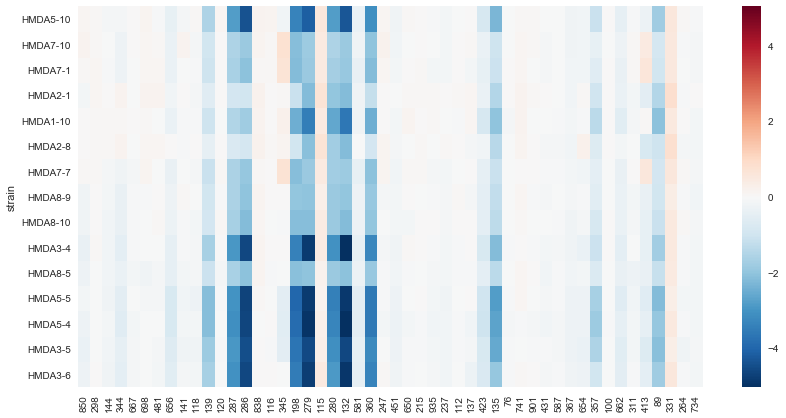

In [143]:
plot_df = test_df.copy()
plot_df = plot_df.sort_values("tol")
plot_df = plot_df[plot_df.corr()["tol"].sort_values().index]
plt.figure(figsize=[14, 7])
sbn.heatmap(plot_df.iloc[:, :50])

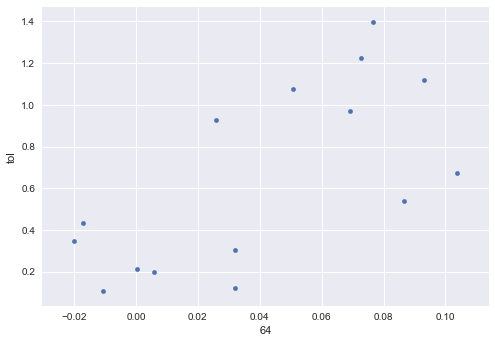

In [132]:
plot_df.plot(kind="scatter", x="64", y="tol")

In [136]:
model.metabolites.acglc__D_c.reactions

frozenset({<Reaction GLCATr at 0x131b1c668>})

In [137]:
model.reactions.GLCATr

Reaction identifier,GLCATr
Name,D-glucose O-acetyltransferase
Memory address,0x0131b1c668
Stoichiometry,accoa_c + glc__D_c <=> acglc__D_c + coa_c Acetyl-CoA + D-Glucose <=> 6-Acetyl-D-glucose + Coenzyme A
GPR,b0459
Lower bound,-1000.0
Upper bound,1000.0


In [7]:
nagC_pssm = [
    [6, 3, 16, 8, 1, 0, 0, 10, 0, 2, 12, 6, 4, 9, 8, 19, 20, 12, 2, 18, 9, 3],
    [1, 2, 0, 0, 0, 0, 13, 0, 13, 4, 2, 5, 0, 9, 0, 1, 0, 0, 2, 0, 0, 7],
    [2, 0, 0, 1, 0, 0, 0, 9, 0, 12, 2, 1, 9, 2, 8, 0, 0, 3, 2, 1, 3, 7],
    [11, 15, 4, 11, 19, 20, 7, 1, 7, 2, 4, 8, 7, 0, 4, 0, 0, 5, 14, 1, 8, 3]
]
nagC_pssm = np.array(nagC_pssm)
nagC_pssm = nagC_pssm / 20

In [8]:
np.log(nagC_pssm).sum()

/Users/krisj/anaconda/envs/cfb_old/lib/python3.4/site-packages/ipykernel/__main__.py:1 RuntimeWarning: divide by zero encountered in log


-inf

In [9]:
nuc_to_num = {"A": 0, "C": 1, "G": 2, "T": 3}

def dna_to_arr(string):
    length = len(string)
    out = np.zeros([4, length])
    for i, c in enumerate(string):
        out[nuc_to_num[c], i] = 1
    return out

In [19]:
%%time

hits = []

for i in range((len(genome) - 12) // 1):
    substr = [genome[i]]
    if substr[0] != "T":
        continue
    for j in range(1, 13):
        substr.append(genome[i+j])
    if substr[0] == "T" and substr[1] == "T" and substr[-2] == "A" and substr[-1] == "A":
        hits.append(i)

CPU times: user 22.9 s, sys: 52.3 ms, total: 23 s
Wall time: 23.1 s


In [20]:
len(hits)

24631

In [43]:
%timeit genome[i: i+13]

100 loops, best of 3: 11 ms per loop
